In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

# Scalers
from sklearn.preprocessing import StandardScaler

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder

from aif360.sklearn.preprocessing import ReweighingMeta
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta
from aif360.sklearn.datasets import fetch_compas
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error, generalized_fpr
from aif360.sklearn.metrics import generalized_fnr, difference

In [6]:
X, y = fetch_compas()
X.head(10)

,,,sex,age,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc
id,sex,race,,,,,,,,,,
1,Male,Other,Male,69,Greater than 45,Other,0,0,0,0,F,Aggravated Assault w/Firearm
3,Male,African-American,Male,34,25 - 45,African-American,0,0,0,0,F,Felony Battery w/Prior Convict
4,Male,African-American,Male,24,Less than 25,African-American,0,0,1,4,F,Possession of Cocaine
7,Male,Other,Male,44,25 - 45,Other,0,0,0,0,M,Battery
8,Male,Caucasian,Male,41,25 - 45,Caucasian,0,0,0,14,F,Possession Burglary Tools
9,Male,Other,Male,43,25 - 45,Other,0,0,0,3,F,arrest case no charge
10,Female,Caucasian,Female,39,25 - 45,Caucasian,0,0,0,0,M,Battery
14,Male,Caucasian,Male,27,25 - 45,Caucasian,0,0,0,0,F,"Poss 3,4 MDMA (Ecstasy)"
15,Male,African-American,Male,23,Less than 25,African-American,0,0,0,3,M,Battery


In [7]:
X.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names=y.index.names)

In [8]:
y = pd.Series(y.factorize(sort=True)[0], index=y.index)

In [9]:
(X_train, X_test,
 y_train, y_test) = train_test_split(X, y, train_size=0.7, random_state=1234567)

In [10]:
ohe = make_column_transformer((OneHotEncoder(sparse=False, handle_unknown='ignore'), X_train.dtypes == 'category'), remainder='passthrough')
X_train  = pd.DataFrame(ohe.fit_transform(X_train), index=X_train.index)
X_test = pd.DataFrame(ohe.transform(X_test), index=X_test.index)

X_train.head()

,,,0,1,2,3,4,5,6,7,8,9,...,339,340,341,342,343,344,345,346,347,348
id,sex,race,,,,,,,,,,,,,,,,,,,,,
2106,0,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0
5330,0,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,1.0
5916,0,5,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0
4158,1,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,51.0,0.0,0.0,0.0,0.0
4029,0,0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,1.0


In [11]:
# X.juv.cat.remove_unused_categories(inplace=True)
# pd.get_dummies(X).head()
pd.get_dummies(X,drop_first=True).head()

,,,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,sex_Female,age_cat_Greater than 45,age_cat_Less than 25,race_Asian,race_Caucasian,...,c_charge_desc_Video Voyeur-<24Y on Child >16,c_charge_desc_Viol Injunct Domestic Violence,c_charge_desc_Viol Injunction Protect Dom Vi,c_charge_desc_Viol Pretrial Release Dom Viol,c_charge_desc_Viol Prot Injunc Repeat Viol,c_charge_desc_Violation License Restrictions,c_charge_desc_Violation Of Boater Safety Id,c_charge_desc_Violation of Injunction Order/Stalking/Cyberstalking,c_charge_desc_Voyeurism,c_charge_desc_arrest case no charge
id,sex,race,,,,,,,,,,,,,,,,,,,,,
0,0,5,69,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,34,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,24,0,0,1,4,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,5,44,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,2,41,0,0,0,14,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [12]:
y_train.head()
X_train.head()

,,,0,1,2,3,4,5,6,7,8,9,...,339,340,341,342,343,344,345,346,347,348
id,sex,race,,,,,,,,,,,,,,,,,,,,,
2106,0,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0
5330,0,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,1.0
5916,0,5,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0
4158,1,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,51.0,0.0,0.0,0.0,0.0
4029,0,0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,1.0


In [25]:
y_pred = LogisticRegression(solver='lbfgs', max_iter=1000).fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_pred)

0.6720691518098325

In [26]:
disparate_impact_ratio(y_test, y_pred, prot_attr='sex')

2.2575861424387815

In [34]:
average_odds_error(y_test, y_pred, prot_attr='sex')

0.2234924856733131

In [35]:
rew = ReweighingMeta(estimator=LogisticRegression(solver='lbfgs', max_iter=10000))

params = {'estimator__C': [1, 10], 'reweigher__prot_attr': ['sex']}

clf = GridSearchCV(rew, params, scoring='accuracy', cv=5)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print(clf.best_params_)

0.6645056726094003
{'estimator__C': 1, 'reweigher__prot_attr': 'sex'}


In [30]:
disparate_impact_ratio(y_test, clf.predict(X_test), prot_attr='sex')

1.1668826263364067

In [31]:
adv_deb = AdversarialDebiasing(prot_attr='sex', random_state=1234567)
adv_deb.fit(X_train, y_train)
adv_deb.score(X_test, y_test)

0.6601836844948676

In [32]:
average_odds_error(y_test, adv_deb.predict(X_test), prot_attr='sex')

0.03468226609024097

In [33]:
disparate_impact_ratio(y_test, adv_deb.predict(X_test), prot_attr='sex')

1.0048949501600168

In [36]:
adv_deb.sess_.close()

In [38]:
cal_eq_odds = CalibratedEqualizedOdds('sex', cost_constraint='fnr', random_state=1234567)
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000)
postproc = PostProcessingMeta(estimator=log_reg, postprocessor=cal_eq_odds, random_state=1234567)

postproc.fit(X_train, y_train)
accuracy_score(y_test, postproc.predict(X_test))

0.55537547271745

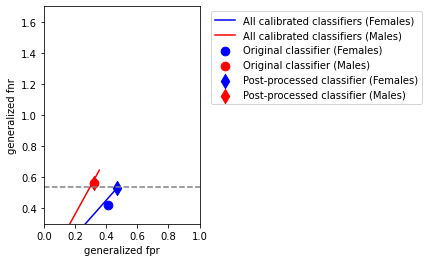

In [46]:
y_pred = postproc.predict_proba(X_test)[:, 1]
y_lr = postproc.estimator_.predict_proba(X_test)[:, 1]
br = postproc.postprocessor_.base_rates_
i = X_test.index.get_level_values('sex') == 1

plt.plot([0, br[0]], [0, 1-br[0]], '-b', label='All calibrated classifiers (Females)')
plt.plot([0, br[1]], [0, 1-br[1]], '-r', label='All calibrated classifiers (Males)')

plt.scatter(generalized_fpr(y_test[~i], y_lr[~i]),
            generalized_fnr(y_test[~i], y_lr[~i]),
            300, c='b', marker='.', label='Original classifier (Females)')
plt.scatter(generalized_fpr(y_test[i], y_lr[i]),
            generalized_fnr(y_test[i], y_lr[i]),
            300, c='r', marker='.', label='Original classifier (Males)')
                                                                        
plt.scatter(generalized_fpr(y_test[~i], y_pred[~i]),
            generalized_fnr(y_test[~i], y_pred[~i]),
            100, c='b', marker='d', label='Post-processed classifier (Females)')
plt.scatter(generalized_fpr(y_test[i], y_pred[i]),
            generalized_fnr(y_test[i], y_pred[i]),
            100, c='r', marker='d', label='Post-processed classifier (Males)')

plt.plot([0, 1], [generalized_fnr(y_test, y_pred)]*2, '--', c='0.5')

plt.axis('square')
plt.xlim([0.0, 1.0])
plt.ylim([0.3, 1.7])
plt.xlabel('generalized fpr');
plt.ylabel('generalized fnr');
plt.legend(bbox_to_anchor=(1.04,1), loc='upper left');

In [40]:
difference(generalized_fnr, y_test, y_pred, prot_attr='sex')

-0.030766564205133018